In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.autograd import Variable as V

import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ML_P2_QuantumMinds/epfl_augmented.zip -d data
!nvidia-smi

Streaming output truncated to the last 5000 lines.
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip0_rot270.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip0_rot315.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip0_rot360.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip0_rot45.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip0_rot90.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot0.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot135.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot180.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot225.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot270.png  
  inflating: data/epfl_augmented/train/groundtruth/satImage_037_flip1_rot315.png  
  inflating: data/epfl_augmented/train/g

In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def load_images_and_labels(data_dir):
    image_dir = os.path.join(data_dir, "images")
    label_dir = os.path.join(data_dir, "groundtruth")
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    num_files = len(image_files)

    # Load the first image to determine dimensions
    sample_image = np.array(Image.open(os.path.join(image_dir, image_files[0]))).astype(float) / 255
    sample_label = np.array(Image.open(os.path.join(label_dir, label_files[0]))).astype(float) / 255
    sample_label = np.expand_dims(sample_label, 2)
    sample_image = np.transpose(sample_image, (2, 0, 1))
    sample_label = np.transpose(sample_label, (2, 0, 1))

    # Pre-allocate arrays
    images = np.zeros((num_files, *sample_image.shape), dtype=np.float32)
    labels = np.zeros((num_files, *sample_label.shape), dtype=np.float32)

    for idx, (img_file, lbl_file) in tqdm(enumerate(zip(image_files, label_files)), total=num_files):
        image = np.array(Image.open(os.path.join(image_dir, img_file))).astype(float) / 255
        label = np.array(Image.open(os.path.join(label_dir, lbl_file))).astype(float) / 255
        label = np.expand_dims(label, 2)
        image = np.transpose(image, (2, 0, 1))
        label = np.transpose(label, (2, 0, 1))
        images[idx] = image
        labels[idx] = label

    return images, labels

train_images, train_labels = load_images_and_labels("data/epfl_augmented/train")
val_images, val_labels = load_images_and_labels("data/epfl_augmented/validation")


100%|██████████| 276/276 [00:01<00:00, 257.99it/s]


In [5]:
class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCEWithLogitsLoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def __call__(self, y_true, y_pred):
        a =  self.bce_loss(y_pred, y_true)
        b =  self.soft_dice_loss(y_true, y_pred)
        return a + b


In [6]:
import torch
import torch.nn as nn

from torch.autograd import Variable
from torchvision import models
import torch.nn.functional as F
from functools import partial

nonlinearity = partial(F.relu, inplace=True)


#CBAM改

class Channel(nn.Module ):
    def __init__(self,inchannel,reduction=16):
        super(Channel, self).__init__()
        radio=reduction //2


        self.gap=nn.AdaptiveAvgPool2d(1)
        self.gmp=nn.AdaptiveMaxPool2d (1)

        self.mlp=nn.Sequential (
            nn.Conv2d(inchannel ,inchannel //radio ,1,1,0,bias= False ),
            nn.ReLU (),
            nn.Conv2d (inchannel //radio,inchannel//reduction ,1,1,0,bias= False ),
            nn.ReLU (),
            nn.Conv2d (inchannel //reduction ,inchannel//radio ,1,1,0,bias= False ),
            nn.ReLU (),
            nn.Conv2d (inchannel//radio,inchannel ,1,1,0,bias= False )
        )
        self.sig=nn.Sigmoid ()

    def forward(self,x):

        gap=self.gap (x)
        gmp=self.gmp(x)

        gap=self.mlp(gap)
        gmp=self.mlp(gmp)


        return self.sig(gap+gmp)


class Spatial(nn.Module ):
    def __init__(self):
        super(Spatial, self).__init__()

        self.conv=nn.Sequential (

            nn.Conv2d (in_channels= 2,out_channels= 2,kernel_size= 3,stride= 1,padding= 1,bias= False ),
            nn.ReLU (),
            nn.Conv2d (in_channels= 2,out_channels= 2,kernel_size= 3,stride= 1,padding= 1,bias= False ),
            nn.ReLU (),
            nn.Conv2d (in_channels= 2,out_channels= 1,kernel_size= 3,stride= 1,padding= 1,bias= False )
        )

        self.sig=nn.Sigmoid ()

    def forward(self,x):

        max_pool,_=torch.max (x,dim=1,keepdim= True)
        avg_pool  =torch.mean(x,dim=1,keepdim= True)

        cc=torch.cat([max_pool ,avg_pool ],dim= 1)

        cc=self.conv (cc)

        cc=self.sig(cc)

        return cc


class CBAMs(nn.Module ):
    def __init__(self,inchannel,reduction):
        super(CBAMs, self).__init__()

        self.channel=Channel (inchannel ,reduction )
        self.spatial=Spatial ()

    def forward(self,x):

        ca=self.channel (x)
        out=ca*x
        sa=self.spatial (out)
        out=out*sa

        return out

class Dblock(nn.Module):
    def __init__(self, channel,d_bin):
        super(Dblock, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=d_bin[0], padding=d_bin[0])
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=d_bin[1], padding=d_bin[1])
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=d_bin[2], padding=d_bin[2])
        self.dilate4 = nn.Conv2d(channel, channel, kernel_size=3, dilation=d_bin[3], padding=d_bin[3])
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        self.att=CBAMs(channel,16)

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate2(dilate1_out))
        dilate3_out = nonlinearity(self.dilate3(dilate2_out))
        dilate4_out = nonlinearity(self.dilate4(dilate3_out))

        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return self.att(out)


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x
class RFE_LINKNET(nn.Module):
    def __init__(self, num_classes=1, num_channels=3):
        super(RFE_LINKNET, self).__init__()

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dblock1=Dblock(64,d_bin=[1,32,32,64])
        self.dblock2=Dblock(128,d_bin=[1,16,16,32])
        self.dblock3=Dblock(256,d_bin=[1,4,8,16])
        self.dblock4=Dblock(512,d_bin=[1,2,4,8])


        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])



        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center

        e4=self.dblock4(e4)

        # Decoder
        d4 = self.decoder4(e4)+self.dblock3(e3)
        d3 = self.decoder3(d4)+self.dblock2(e2)
        d2 = self.decoder2(d3)+self.dblock1(e1)
        d1 = self.decoder1(d2)

        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return F.sigmoid(out)



In [7]:
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def train(model, images_training, labels_training, images_validation, labels_validation,
          loss_func, batch_size=8, learning_rate=1e-3, epochs=50, path_model='models/'):
    """
    Train the instance of the neural network and track losses.
    Args:
        model (torch): the instance of the neural network
        images_training, labels_training (numpy): training dataset
        images_validation, labels_validation (numpy): validation dataset
        loss_func (class): the loss function
        batch_size (int): the number of samples per batch to load (default: 8)
        learning_rate (float): the learning rate (default: 1e-3)
        epochs (int): the number of epochs (default: 50)
        path_model (str): path to save the trained model
    """
    # Prepare DataLoaders
    def prepare_loader(images, labels):
        dataset = TensorDataset(torch.Tensor(images), torch.Tensor(labels))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_loader = prepare_loader(images_training, labels_training)
    val_loader = prepare_loader(images_validation, labels_validation)

    # Ensure the save directory exists
    os.makedirs(path_model, exist_ok=True)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)

    best_val_loss = float('inf')  # Initialize best validation loss
    best_model_path = f"{path_model}/best_model.pth"  # Path to save the best model

    # Lists to store losses for plotting
    training_losses = []
    validation_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training
        model.train()
        training_loss = 0
        for inputs, labels in train_loader:
            # Transfer to GPU
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        training_losses.append(training_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {training_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Transfer to GPU
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                validation_loss += loss_func(outputs, labels).item()

        validation_losses.append(validation_loss / len(val_loader))
        print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {validation_loss / len(val_loader):.4f}")

        # Save the best model based on validation loss
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
            }, best_model_path)
            print("Saved best model")

        scheduler.step()

        # Save checkpoint for the current epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
        }, f"{path_model}/model_epoch_{epoch + 1}.pth")

In [19]:
model = RFE_LINKNET(num_classes=1, num_channels=3)  # Adjust parameters if necessary
model.cuda()
train(model,
      train_images,
      train_labels,
      val_images,
      val_labels,
      loss_func=dice_bce_loss(),
      batch_size=4,
      learning_rate=1e-4,
      epochs=30,
      path_model='model')



Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Training Loss: 0.9827
Epoch 1/30 - Validation Loss: 0.9676
Saved best model


Training Progress:   3%|▎         | 1/30 [00:32<15:33, 32.19s/it]

Epoch 2/30 - Training Loss: 0.7737
Epoch 2/30 - Validation Loss: 1.0638


Training Progress:   7%|▋         | 2/30 [01:05<15:14, 32.66s/it]

Epoch 3/30 - Training Loss: 0.7463
Epoch 3/30 - Validation Loss: 0.9761


Training Progress:  10%|█         | 3/30 [01:39<14:59, 33.32s/it]

Epoch 4/30 - Training Loss: 0.7310
Epoch 4/30 - Validation Loss: 0.9152
Saved best model


Training Progress:  13%|█▎        | 4/30 [02:14<14:47, 34.14s/it]

Epoch 5/30 - Training Loss: 0.7187
Epoch 5/30 - Validation Loss: 0.9552


Training Progress:  17%|█▋        | 5/30 [02:48<14:14, 34.20s/it]

Epoch 6/30 - Training Loss: 0.7121
Epoch 6/30 - Validation Loss: 0.9260


Training Progress:  20%|██        | 6/30 [03:20<13:17, 33.24s/it]

Epoch 7/30 - Training Loss: 0.7086
Epoch 7/30 - Validation Loss: 0.9036
Saved best model


Training Progress:  23%|██▎       | 7/30 [03:52<12:34, 32.78s/it]

Epoch 8/30 - Training Loss: 0.7041
Epoch 8/30 - Validation Loss: 0.9538


Training Progress:  27%|██▋       | 8/30 [04:23<11:48, 32.22s/it]

Epoch 9/30 - Training Loss: 0.7020
Epoch 9/30 - Validation Loss: 0.9850


Training Progress:  30%|███       | 9/30 [04:54<11:08, 31.84s/it]

Epoch 10/30 - Training Loss: 0.6989
Epoch 10/30 - Validation Loss: 0.9854


Training Progress:  33%|███▎      | 10/30 [05:24<10:30, 31.51s/it]

Epoch 11/30 - Training Loss: 0.6919
Epoch 11/30 - Validation Loss: 0.9374


Training Progress:  37%|███▋      | 11/30 [05:55<09:53, 31.25s/it]

Epoch 12/30 - Training Loss: 0.6886
Epoch 12/30 - Validation Loss: 0.9323


Training Progress:  40%|████      | 12/30 [06:26<09:20, 31.14s/it]

Epoch 13/30 - Training Loss: 0.6878
Epoch 13/30 - Validation Loss: 0.9424


Training Progress:  43%|████▎     | 13/30 [06:57<08:48, 31.10s/it]

Epoch 14/30 - Training Loss: 0.6875
Epoch 14/30 - Validation Loss: 0.9900


Training Progress:  47%|████▋     | 14/30 [07:28<08:17, 31.10s/it]

Epoch 15/30 - Training Loss: 0.6865
Epoch 15/30 - Validation Loss: 0.9720


Training Progress:  50%|█████     | 15/30 [07:59<07:46, 31.11s/it]

Epoch 16/30 - Training Loss: 0.6859
Epoch 16/30 - Validation Loss: 0.9803


Training Progress:  53%|█████▎    | 16/30 [08:31<07:18, 31.35s/it]

Epoch 17/30 - Training Loss: 0.6860
Epoch 17/30 - Validation Loss: 0.9781


Training Progress:  57%|█████▋    | 17/30 [09:03<06:48, 31.42s/it]

Epoch 18/30 - Training Loss: 0.6852
Epoch 18/30 - Validation Loss: 0.9769


Training Progress:  60%|██████    | 18/30 [09:34<06:15, 31.33s/it]

Epoch 19/30 - Training Loss: 0.6843
Epoch 19/30 - Validation Loss: 0.9760


Training Progress:  63%|██████▎   | 19/30 [10:05<05:44, 31.32s/it]

Epoch 20/30 - Training Loss: 0.6843
Epoch 20/30 - Validation Loss: 0.9615


Training Progress:  67%|██████▋   | 20/30 [10:36<05:13, 31.31s/it]

Epoch 21/30 - Training Loss: 0.6817
Epoch 21/30 - Validation Loss: 0.9716


Training Progress:  70%|███████   | 21/30 [11:08<04:41, 31.29s/it]

Epoch 22/30 - Training Loss: 0.6803
Epoch 22/30 - Validation Loss: 0.9721


Training Progress:  73%|███████▎  | 22/30 [11:39<04:10, 31.32s/it]

Epoch 23/30 - Training Loss: 0.6801
Epoch 23/30 - Validation Loss: 0.9807


Training Progress:  77%|███████▋  | 23/30 [12:10<03:39, 31.34s/it]

Epoch 24/30 - Training Loss: 0.6798
Epoch 24/30 - Validation Loss: 0.9558


Training Progress:  80%|████████  | 24/30 [12:42<03:08, 31.45s/it]

Epoch 25/30 - Training Loss: 0.6797
Epoch 25/30 - Validation Loss: 0.9257


Training Progress:  83%|████████▎ | 25/30 [13:15<02:38, 31.75s/it]

Epoch 26/30 - Training Loss: 0.6794
Epoch 26/30 - Validation Loss: 0.9869


Training Progress:  87%|████████▋ | 26/30 [13:47<02:07, 31.83s/it]

Epoch 27/30 - Training Loss: 0.6792
Epoch 27/30 - Validation Loss: 0.9408


Training Progress:  90%|█████████ | 27/30 [14:18<01:35, 31.74s/it]

Epoch 28/30 - Training Loss: 0.6791
Epoch 28/30 - Validation Loss: 0.9730


Training Progress:  93%|█████████▎| 28/30 [14:50<01:03, 31.82s/it]

Epoch 29/30 - Training Loss: 0.6788
Epoch 29/30 - Validation Loss: 0.9507


Training Progress:  97%|█████████▋| 29/30 [15:22<00:31, 31.83s/it]

Epoch 30/30 - Training Loss: 0.6788
Epoch 30/30 - Validation Loss: 0.9728


Training Progress: 100%|██████████| 30/30 [15:54<00:00, 31.82s/it]


In [ ]:
checkpoint = torch.load('model/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-18-266da356fa3a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model/best_model.pth')


<All keys matched successfully>

In [20]:
!unzip /content/drive/MyDrive/ML_P2_QuantumMinds/test.zip -d data

Archive:  /content/drive/MyDrive/ML_P2_QuantumMinds/test.zip
   creating: data/test/
   creating: data/test/test_set_images/
   creating: data/test/test_set_images/test_1/
  inflating: data/test/test_set_images/test_1/test_1.png  
   creating: data/test/test_set_images/test_10/
  inflating: data/test/test_set_images/test_10/test_10.png  
   creating: data/test/test_set_images/test_11/
  inflating: data/test/test_set_images/test_11/test_11.png  
   creating: data/test/test_set_images/test_12/
  inflating: data/test/test_set_images/test_12/test_12.png  
   creating: data/test/test_set_images/test_13/
  inflating: data/test/test_set_images/test_13/test_13.png  
   creating: data/test/test_set_images/test_14/
  inflating: data/test/test_set_images/test_14/test_14.png  
   creating: data/test/test_set_images/test_15/
  inflating: data/test/test_set_images/test_15/test_15.png  
   creating: data/test/test_set_images/test_16/
  inflating: data/test/test_set_images/test_16/test_16.png  
   cre

  0%|          | 0/50 [00:00<?, ?it/s]

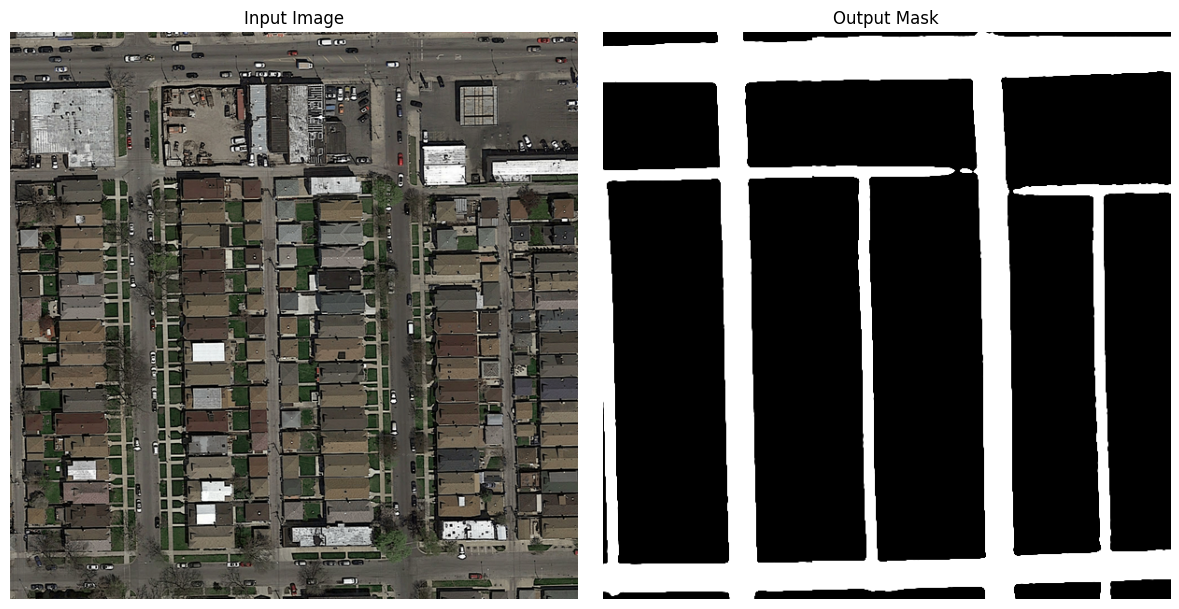

  2%|▏         | 1/50 [00:00<00:26,  1.88it/s]

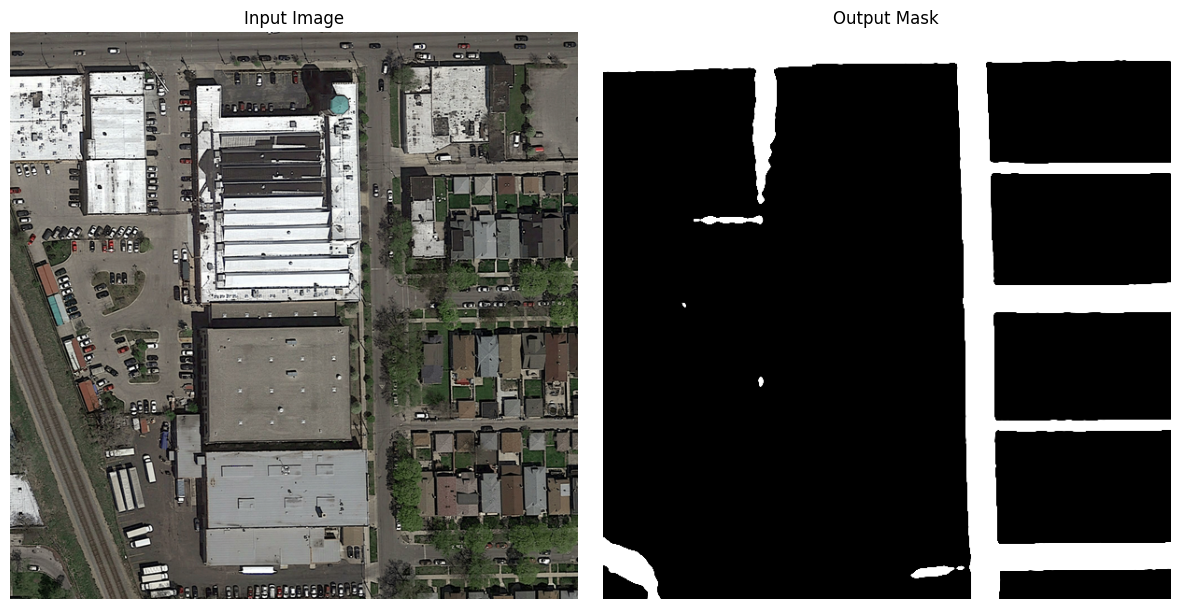

  4%|▍         | 2/50 [00:01<00:25,  1.90it/s]

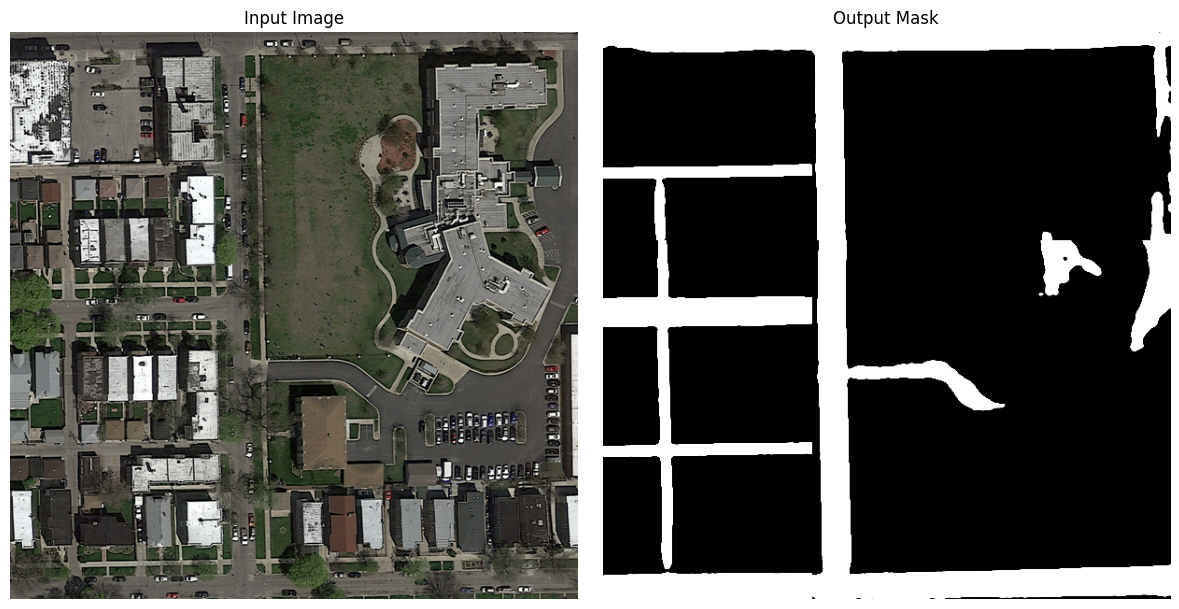

  6%|▌         | 3/50 [00:01<00:25,  1.86it/s]

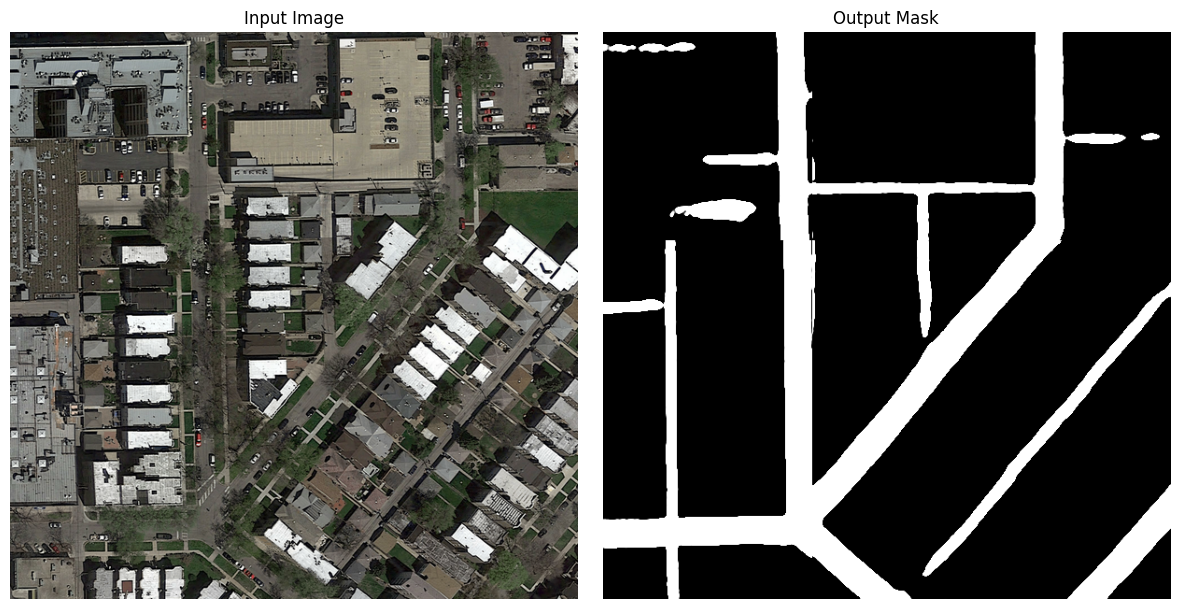

  8%|▊         | 4/50 [00:02<00:25,  1.81it/s]

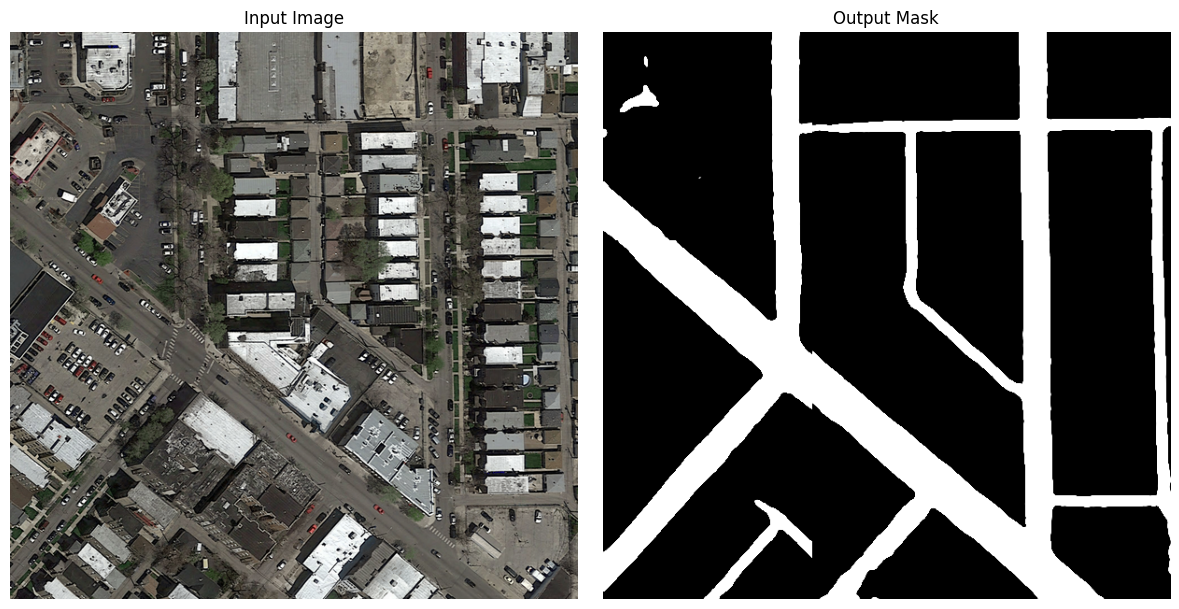

 10%|█         | 5/50 [00:02<00:25,  1.79it/s]

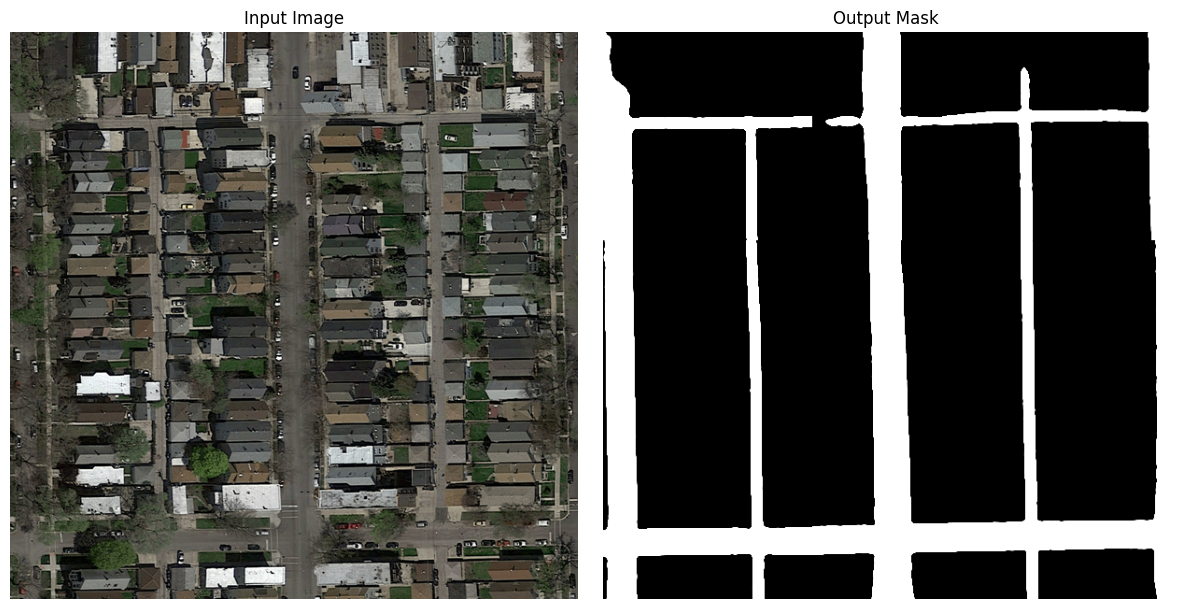

 12%|█▏        | 6/50 [00:03<00:24,  1.79it/s]

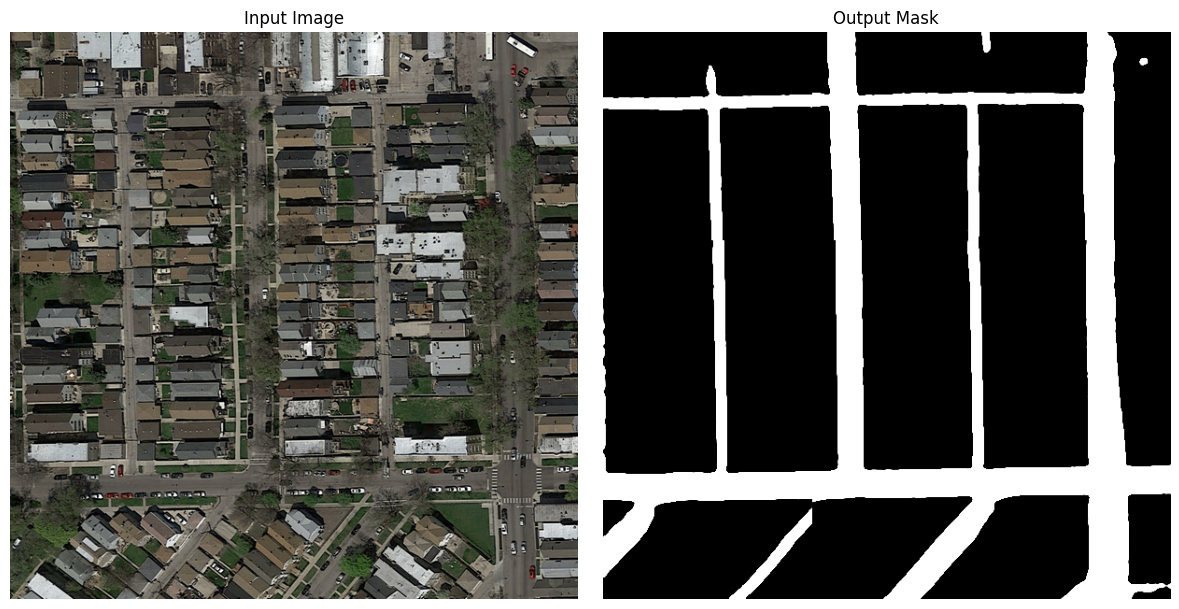

 14%|█▍        | 7/50 [00:03<00:23,  1.80it/s]

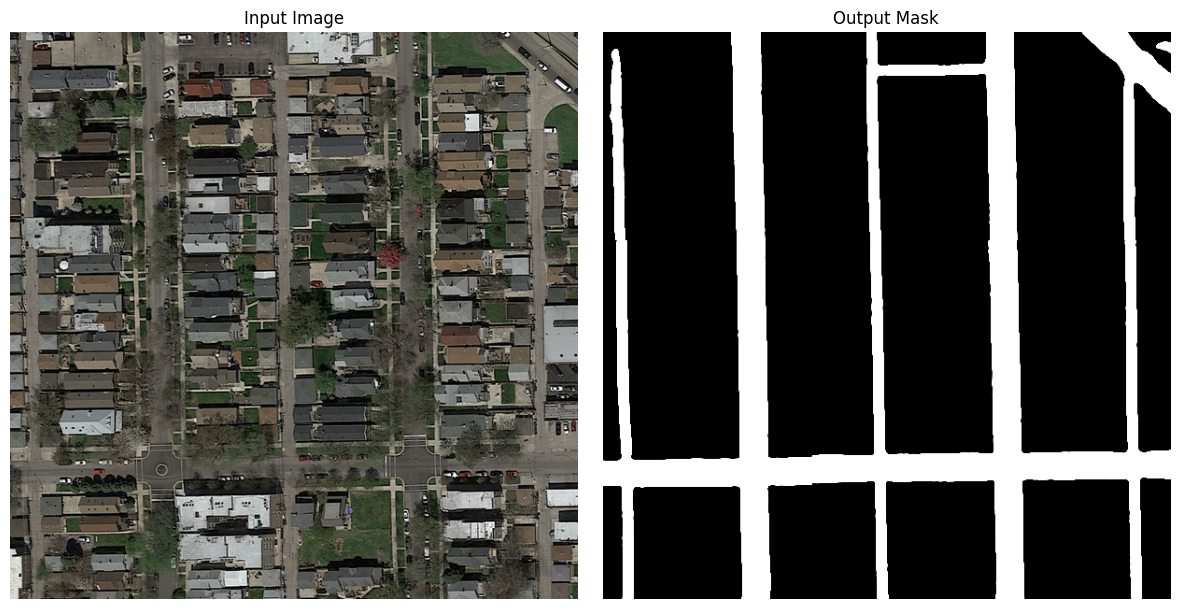

 16%|█▌        | 8/50 [00:04<00:22,  1.86it/s]

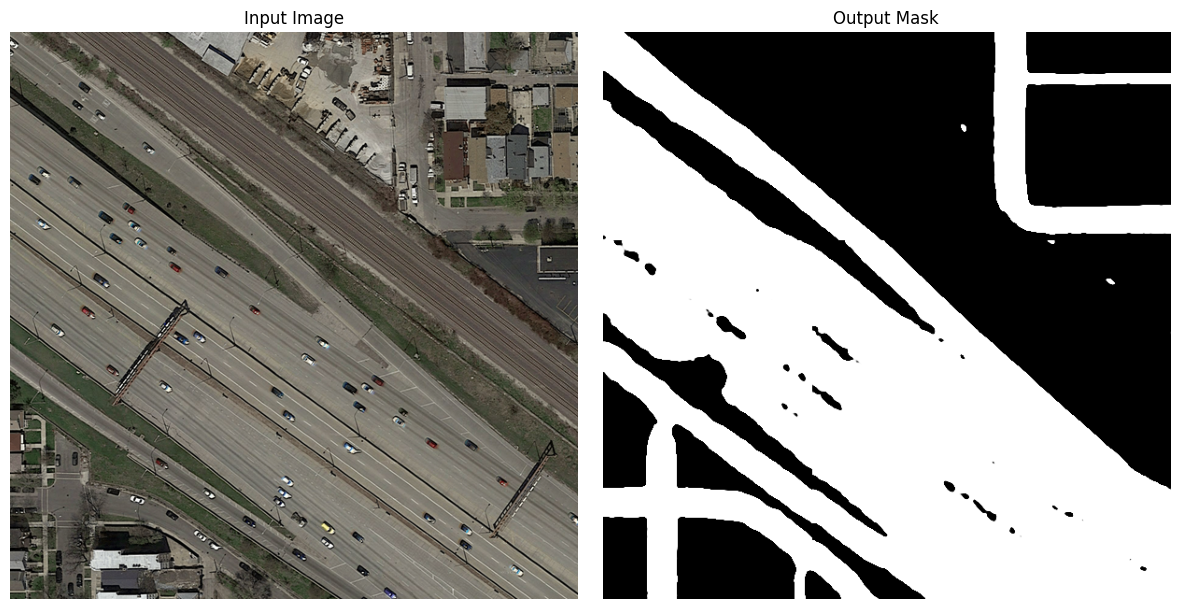

 18%|█▊        | 9/50 [00:04<00:21,  1.90it/s]

In [ ]:
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

def extract_patches(input_image, patch_size=384):
    """
    Extracts 4 non-overlapping patches from a 608x608 input image.
    """
    patches = np.empty((4, input_image.shape[2], patch_size, patch_size))
    offsets = [(0, 0), (0, 224), (224, 0), (224, 224)]

    for i, (y, x) in enumerate(offsets):
        patches[i] = np.transpose(input_image[y:y+patch_size, x:x+patch_size, :], (2, 0, 1))

    return patches

def assemble_patches(patches):
    """
    Assembles 4 patches back into a 608x608 output.
    """
    output = np.empty((patches.shape[1], 608, 608))
    offsets = [(0, 0), (0, 224), (224, 0), (224, 224)]

    for i, (y, x) in enumerate(offsets):
        output[:, y:y+384, x:x+384] = patches[i]

    return output

def mask_to_submission_format(mask, index):
    """
    Converts a mask into the submission format.
    """
    submission = []
    for y in range(0, mask.shape[0], 16):
        for x in range(0, mask.shape[1], 16):
            patch = mask[y:y+16, x:x+16]
            prediction = 1 if np.mean(patch > 0.2) > 0.25 else 0
            submission.append([f"{index:03d}_{x}_{y}", prediction])
    return submission

def create_submission(model, test_images_path='test_set_images/', patch_size=384, cuda=True):
    """
    Generates a submission file by predicting masks for the test set images.
    """
    all_submissions = []

    for index in tqdm(range(1, 51)):
        model.eval()

        # Load and preprocess the test image
        input_image = np.array(Image.open(f'{test_images_path}/test_{index}/test_{index}.png')).astype('float32') / 255
        input_patches = extract_patches(input_image)
        input_patches = torch.from_numpy(input_patches).float()

        # Perform inference
        if cuda:
            predictions = model(input_patches.cuda()).detach().cpu().numpy()
        else:
            predictions = model(input_patches).detach().numpy()

        # Assemble patches into a full mask
        output_mask = assemble_patches(predictions)[0]

        # Visualize input and output side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row and 2 columns of plots
        axes[0].imshow(input_image)
        axes[0].set_title('Input Image')
        axes[0].axis('off')  # Hide axes for better visualization

        axes[1].imshow(output_mask, cmap='gray')
        axes[1].set_title('Output Mask')
        axes[1].axis('off')  # Hide axes for better visualization

        plt.tight_layout()  # Adjust spacing between plots
        plt.show()


        # Convert mask to submission format
        submission = mask_to_submission_format(output_mask, index)
        all_submissions.extend(submission)

    # Add header to submission
    submission = [['id', 'prediction']] + all_submissions
    return np.array(submission)

# Example usage
submission = create_submission(model, 'data/test/test_set_images', 384, True)
np.savetxt("submit.csv", submission, delimiter=",", fmt='%s')